# **Exploratory Data Analysis**
---

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('dark_background')

import scipy.stats as st
from sklearn import preprocessing as pre

In [2]:
RANDOM_STATE = 42

In [ ]:
flights = pd.read_csv('../Data/files/flights_no_missing.csv') # run data_overview.ipynb to obtain this file.
flights.columns

Index(['fl_date', 'mkt_unique_carrier', 'branded_code_share', 'mkt_carrier',
       'mkt_carrier_fl_num', 'op_unique_carrier', 'tail_num',
       'op_carrier_fl_num', 'origin_airport_id', 'origin', 'origin_city_name',
       'dest_airport_id', 'dest', 'dest_city_name', 'crs_dep_time', 'dep_time',
       'dep_delay', 'taxi_out', 'wheels_off', 'wheels_on', 'taxi_in',
       'crs_arr_time', 'arr_time', 'arr_delay', 'cancelled',
       'cancellation_code', 'diverted', 'dup', 'crs_elapsed_time',
       'actual_elapsed_time', 'air_time', 'flights', 'distance',
       'carrier_delay', 'weather_delay', 'nas_delay', 'security_delay',
       'late_aircraft_delay'],
      dtype='object')

## **2) Recommended exploration tasks**
---

### Motivation:

Our primary objective with this exploratory analysis is to identify the features in our data that best represent our understanding of the [root causes of flight delays](../Research/flight_delay_reasons.md) and in so doing, provide the basis for the **accurate** and **reliable** prediction of commercial flight delays. We aim to develop a sense for how well our feature space captures common flight delay reasons in order to determine which features to select, which additional data to gather, and which features should be re-engineered or excluded.

#### [Suggested considerations](https://github.com/lighthouse-labs/mid-term-project-I/blob/master/exploratory_analysis.ipynb) synopsis:

1. [Test the hypothesis that the arrival delay is from Normal distribution and that mean of the delay is 0. Be careful about the outliers.](#task1)
2. [Is average/median monthly delay different during the year? If so, which months have the biggest delays and what could be the reason?](#task2)
3. [Does the weather affect the delay?](#task3)
4. How are taxi times changing during the day? Does higher traffic lead to longer taxi times?
5. What is the average percentage of delays that exist prior to departure (*i.e.* are arrival delays caused by departure delays)? Are airlines able to lower the delay during the flights?
6. How many states cover 50% of US air traffic?
7. Test the hypothesis that planes fly faster when there is a departure delay.
8. When (which hour) do most 'LONG', 'SHORT', 'MEDIUM' haul flights take off?
9. Find the top 10 the bussiest airports. Does the greatest number of flights mean that the majority of passengers went through a given airport? How much traffic do these 10 airports cover?
10. Do bigger delays lead to bigger fuel consumption per passenger?

### 1) Is the arrival delay normally distributed with a mean of 0?<a id='task1'></a>

#### `arr_delay` distribution

In [4]:
flights['arr_delay'].describe()

count    2.339962e+06
mean     5.466329e+00
std      4.992268e+01
min     -1.290000e+03
25%     -1.500000e+01
50%     -6.000000e+00
75%      8.000000e+00
max      2.692000e+03
Name: arr_delay, dtype: float64

<AxesSubplot:xlabel='arr_delay'>

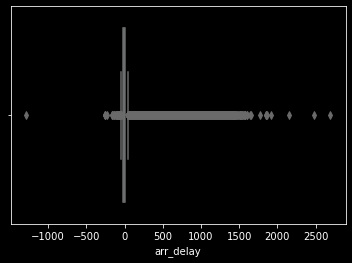

In [5]:
sns.boxplot(x=flights['arr_delay'])

In [6]:
st.normaltest(flights['arr_delay'])

NormaltestResult(statistic=3414284.7469730703, pvalue=0.0)

In [7]:
flights['arr_delay'].shape[0]

2339962

We have strong evidence to reject the null hypothesis that the data is sampled from a normal distribution. Let us attempt a robust [quantile transformation](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.QuantileTransformer.html) to see if we can better normalize the data. [Google](https://developers.google.com/machine-learning/clustering/prepare-data) suggests using ~10x fewer quantiles than the number of observations, so we will attempt that. (Note that this is not a requirement. [Jason Brownlee](https://machinelearningmastery.com/quantile-transforms-for-machine-learning/) found reasonable success using ~2x fewer quantiles than observations, but that was with a much smaller dataset and the number of rows we have here is so large that we should avoid too high of a subsample to prevent the operation from becoming prohibitively computationally expensive for the limited time we have to complete this project.)

In [8]:
quantile_transformer = pre.QuantileTransformer(n_quantiles=250000,
                                               subsample=250000,
                                               output_distribution='normal',
                                               random_state=RANDOM_STATE,
                                               )

In [9]:
quantile_delay = quantile_transformer.fit_transform(flights['arr_delay'].to_numpy().reshape(-1, 1))

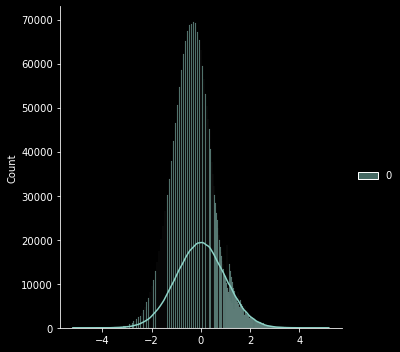

In [10]:
sns.displot(quantile_delay, kde=True)

In [11]:
st.normaltest(quantile_delay)

NormaltestResult(statistic=array([16.40402169]), pvalue=array([0.0002741]))

#### Outlier inspection

A quantile transformation on its own is insufficient to justify the assumption of normality using a reasonable subsample size. We should first deal with outliers. To do so we will compare them on the basis of z score to filter out values with exceedingly anomolous deviations from the mean.

In [12]:
# Return only rows with flights where the z score of the arrival delay is within 3 standard deviations of the mean.
flights_no_arrival_outliers = flights[(np.abs(st.zscore(flights['arr_delay'])) < 3)]

Now let's check the lost data to ensure that we only eliminated outliers and not actual components of a trend in a wide distribution.

In [13]:
percent_retained = flights_no_arrival_outliers.shape[0] / flights.shape[0] * 100
observations_lost = flights.shape[0] - flights_no_arrival_outliers.shape[0]

print(f'{observations_lost} "outliers" were eliminated, retaining {percent_retained} of the original DataFrame.')

37906 "outliers" were eliminated, retaining 98.38005916335393 of the original DataFrame.


Less than 2% of the data were removed by the above operation. Let us test the assumption of normality again now. We should try to include as much data as possible while supporting the null hypothesis that out data was drawn from a normal distribution.

In [14]:
st.normaltest(flights_no_arrival_outliers.arr_delay)

NormaltestResult(statistic=1108764.9326740047, pvalue=0.0)

It appears that the assumption of normality remains invalid. Let us check the distribution of the pruned DataFrame to get a better intuition for why this may be.

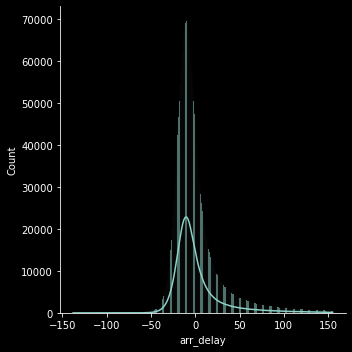

In [15]:
sns.displot(flights_no_arrival_outliers.arr_delay, kde=True)

<AxesSubplot:xlabel='arr_delay'>

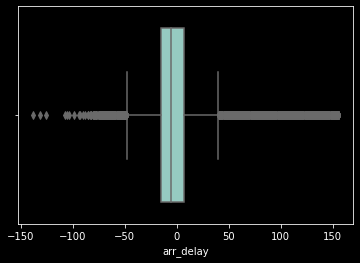

In [16]:
sns.boxplot(x=flights_no_arrival_outliers.arr_delay)

The assumption of normality is most likely violated on the bases that:
1) the right and left tails are asymmetric because more flights are delayed than are early.
2) there are appreciable gaps in the sampled data.  

Let us try applying a quantile transformation on the distribution with outliers removed and see if that helps.

In [17]:
quantile_transformed_arrival_delay_no_outliers = quantile_transformer.fit_transform(
    flights_no_arrival_outliers['arr_delay'].to_numpy().reshape(-1, 1))

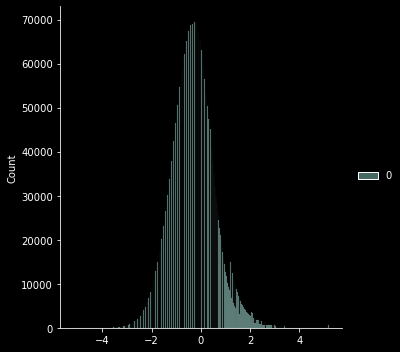

In [18]:
sns.displot(quantile_transformed_arrival_delay_no_outliers)

<AxesSubplot:>

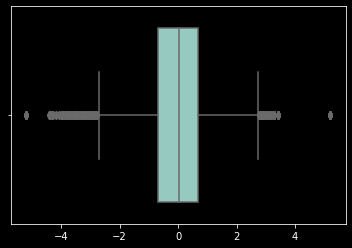

In [19]:
sns.boxplot(x=quantile_transformed_arrival_delay_no_outliers)

In [20]:
st.normaltest(quantile_transformed_arrival_delay_no_outliers)

NormaltestResult(statistic=array([1251.82619391]), pvalue=array([1.47705219e-272]))

It is clear that there is sufficent statistical evidence to reject the null hypothesis that the underlying distribution of the sample from the flights table is normally distributed when outliers are considered to be values 3 or more standard deviations from the mean; however, statistical tests that are robust with respect to the assumption of normality (such as the Student's t-test) may still be applicable.

In [21]:
st.ttest_1samp(flights_no_arrival_outliers['arr_delay'], 0)

Ttest_1sampResult(statistic=56.64040377294951, pvalue=0.0)

In [22]:
st.ttest_1samp(quantile_transformed_arrival_delay_no_outliers, 0)

Ttest_1sampResult(statistic=array([3.07636692]), pvalue=array([0.00209542]))

As we can see above, even using our quantile transformed data with outliers removed provides inadequate support for the null hypothesis that our data is drawn from a normal distribution centered around a mean of 0.

#### monthly comparison

First, we need to establish a column for the month of the year, then we can compare mean and median arrival delays between months. I predict that winter months will have longer delays on average than warmer months because factors like de-icing planes, clearing runways, and visibility issues are likely to be prevalent during these months.

### 2) How do arrival delays differ throughout the year?<a id='task2'></a>

#### monthly comparison

First, we need to establish a column for the month of the year, then we can compare mean and median arrival delays between months. I predict that winter months will have longer delays on average than warmer months because factors like de-icing planes, clearing runways, and visibility issues are likely to be prevalent during these months.

In [23]:
flights['flight_month'] = pd.DatetimeIndex(flights['fl_date']).month # save the month to its own column

In [24]:
monthly_average_delays = flights[['flight_month', 'arr_delay', 'dep_delay']].groupby('flight_month').agg(['mean', 'median'])
monthly_average_delays

arr_delay         dep_delay       
                   mean median       mean median
flight_month                                    
1              3.923047   -7.0   9.769483   -3.0
2              6.693371   -6.0  11.603780   -2.0
3              2.902349   -7.0   8.409256   -2.0
4              4.071800   -7.0   9.264988   -3.0
5              6.448396   -6.0  11.205167   -2.0
6             10.562826   -4.0  14.698757   -1.0
7              8.871938   -5.0  13.661959   -2.0
8              8.883695   -5.0  13.198901   -2.0
9              1.694430   -8.0   6.941369   -3.0
10             2.810083   -6.0   7.441231   -3.0
11             3.071748   -7.0   8.201969   -3.0
12             5.087656   -6.0  10.785105   -2.0

In [25]:
# Remove multilevel column and row indices.
monthly_average_delays = monthly_average_delays.unstack().reset_index()
monthly_average_delays.head()

,level_0,level_1,flight_month,0
0,arr_delay,mean,1,3.923047
1,arr_delay,mean,2,6.693371
2,arr_delay,mean,3,2.902349
3,arr_delay,mean,4,4.071800
4,arr_delay,mean,5,6.448396


In [26]:
# Assign more meaningful column names.
monthly_average_delays = monthly_average_delays.rename(columns={
    'level_0': 'delay_type',
    'level_1': 'metric',
    0: 'delay (mins)',
    })

monthly_average_delays.head()

,delay_type,metric,flight_month,delay (mins)
0,arr_delay,mean,1,3.923047
1,arr_delay,mean,2,6.693371
2,arr_delay,mean,3,2.902349
3,arr_delay,mean,4,4.071800
4,arr_delay,mean,5,6.448396


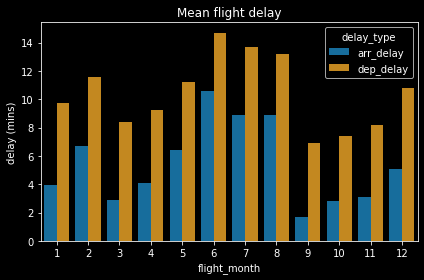

In [27]:
sns.barplot(data=monthly_average_delays[monthly_average_delays.metric == 'mean'],
            x='flight_month',
            y='delay (mins)',
            hue='delay_type',
            palette='colorblind',
            )
plt.title('Mean flight delay')
plt.tight_layout()

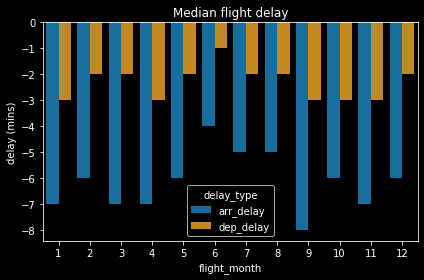

In [28]:
sns.barplot(data=monthly_average_delays[monthly_average_delays.metric == 'median'], 
            x='flight_month',
            y='delay (mins)',
            hue='delay_type',
            palette='colorblind',
            )
plt.title('Median flight delay')
plt.tight_layout()

Taken together, these figures reinforce the idea that many flights are not delayed (suggested by the median [i.e the midpoint of the flight delay observations accounting for 50% of the data]) and even arrive early. This observation is consistent with the statistics reported by the US Department of Transportation. Conversely, the higher mean delay values suggest that the low proportion of flights that are delayed substantially impact the average delay times, thus the median is a better measure of the central tendency of the distribution because it is not skewed by large outlying values, but the mean better captures the effect that long delays are having on flights monthly. Regardless of which metric is used, the departure delay is always greater than the arrival delay. This makes sense because most of the uncertainty regarding delays is encountered prior to departure.

Interestingly, it would appear that my prediction was unsupported by the data, and it is the summer months that experience the highest periods of delay on average. There are two hypotheses that immediately come to mind to explain this divergence from my initial prediction. 1) Winter schedules are typically quite well managed by airlines insofar as they more rigorously adjust their schedules to account for weather related delays. 2) Commercial flights are more frequent in the summer months than in others, and schedulling more flights over a shorter time period creates more opportunity for unexpected circumstances to cause delays.

The first hypothesis can be addressed by comparing the scheduled times of flights between the same origins and destinations in the winter vs. the summer. For hypothesis 1 to gain support, would predict longer scheduled flights than in summer months, and fewer flights scheduled during periods where inclement weather is forcasted. Hypothesis 2 can be addressed by inpecting the overall number of flights in each month and to also consider data regarding demand for flights (number of passengers, cargo, *etc*.).

There are likely many more hypotheses one could test for here as well, but in the interest of time and scope, we will focus on the weather for the time being as we were recommended to explore that factor; however, it would be interesting to return to some of these other analyses if time permits.

### 3) How does the weather affect the delay?<a id='task3'></a>
**Note**: While it is suggested to examine this closely by finding additional data from a weather API for a sample of the flights, in the interest of saving time early on we will only consider the relative delay of weather overall using the data we already have for our first pass and we will return to address this point more rigorously in the future if time permits.

In order to appreciate the impact of weather on flight delays, we should consider it in the context of all features that affect flight delays. Unfortunately, the descriptions of the data we have do not clearly state whether the durations listed on the factor-specific columns contribute to the departure or arrival delay. Hence, we should begin by establishing this.  

Given that our goal is to predict arrival delays, it is sensible to begin by tesing the hypothesis that the specific delay columns should be interpreted in the context of an arrival delay; thus, in observations where they are known to contribute to the delay (i.e. non-zero), they should always sum to a number that is $\leq$ the arrival delay ($<$ to account for missing values). Conversely, there should be no such restriction for the departure delay.

#### Arrival delay hypothesis test

In [29]:
# Colums where the contribution to the delay is specifically known.
specific_delay_columns = ['carrier_delay', 'weather_delay', 'nas_delay', 'security_delay', 'late_aircraft_delay']
# All delay features.
all_delay_columns = ['dep_delay', 'arr_delay'] + specific_delay_columns

In [30]:
total_specific_delay = flights[specific_delay_columns].sum(axis=1) # Calculate the sum across columns for each observation
positive_total_specific_delay = total_specific_delay[total_specific_delay > 0] # Keep observations where we have delay information.
known_specific_delay_indices = positive_total_specific_delay.index # Store the indices where we know what factors contributed to the delay.

In [31]:
# Test our hypothesis that the specific delay information columns are addressing arrival delay. We expact all true if so.
arr_test_results = np.less_equal(positive_total_specific_delay, flights.loc[known_specific_delay_indices]['arr_delay'])

arr_true = arr_test_results.sum()
arr_false = arr_test_results.count() - arr_test_results.sum()

arr_test_results[arr_test_results == False]

1921207    False
dtype: bool

Only 1 index failed the positive control test for our hypothesis. Let us check to see if there is a likely data entry error that may explain this.

In [32]:
flights.iloc[1921207][all_delay_columns]

dep_delay              96.0
arr_delay              67.0
carrier_delay          67.0
weather_delay           0.0
nas_delay              67.0
security_delay          0.0
late_aircraft_delay     0.0
Name: 1921207, dtype: object

Here both carrier and nas delays are listed as 67. This may simply be a data entry error such that the value was mistakenly recorded twice. Let us move on with our next test.

In [33]:
# Negative control for our hypothesis test. This should give a mix of true and false values.
dep_test_results = np.less_equal(positive_total_specific_delay, flights.loc[known_specific_delay_indices]['dep_delay'])

dep_true = dep_test_results.sum()
dep_false = dep_test_results.count() - dep_test_results.sum()

print(f'Total True: {dep_true}\nTotal False: {dep_false}')

Total True: 226840
Total False: 223662


In [34]:
delay_results = pd.DataFrame({
    'Test': ['Positive Control', 'Positive Control', 'Negative Control', 'Negative Control'],
    'Condition': [True, False, True, False],
    'Count': [arr_true, arr_false, dep_true, dep_false],
})
delay_results.head()

,Test,Condition,Count
0,Positive Control,True,450501
1,Positive Control,False,1
2,Negative Control,True,226840
3,Negative Control,False,223662


##### Test summary:

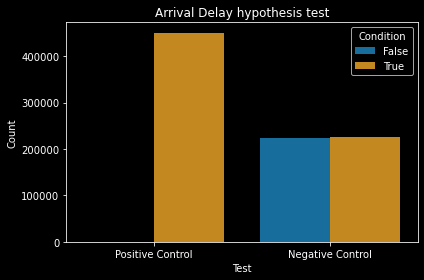

In [35]:
sns.barplot(x='Test',
            y='Count',
            data=delay_results,
            hue='Condition',
            palette='colorblind',
            )
plt.title('Arrival Delay hypothesis test')
plt.tight_layout()

We can see from the above results that our hypothesis that the specific delay columns sum to the arrival delay holds (data entry errors and missing data notwithstanding).

#### Impact of weather on flight delays

In [36]:
flight_departure_delayed = flights[flights['dep_delay'] > 0][all_delay_columns] # Observations where flight departure is delayed.
flight_arrival_delayed = flights[flights['arr_delay'] > 0][all_delay_columns] # Observations where flight arrival is delayed.
# Observations where flights were delayed departing and arriving. 
flight_delayed = flights[(flights['arr_delay'] > 0) & (flights['dep_delay'] > 0)][all_delay_columns]

flight_departure_delayed_percentage = flight_departure_delayed.shape[0] / flights.shape[0] * 100
flight_arrival_delayed_percentage = flight_arrival_delayed.shape[0] / flights.shape[0] * 100
flight_both_delayed_percentage = flight_delayed.shape[0] / flights.shape[0] * 100

print(f'{flight_departure_delayed_percentage:.2f}% of flights were late departing.')
print(f'{flight_arrival_delayed_percentage:.2f}% of flights were late reaching their destination.')
print(f'{flight_both_delayed_percentage:.2f}% of flights were late departing and reaching their destination.')

34.05% of flights were late departing.
35.07% of flights were late reaching their destination.
25.00% of flights were late departing and reaching their destination.


Now that we have some information about the flights experiencing some form of delay, in order to appreciate the impact of the weather on delay, we should find:  
1. In what proportion of these delayed flights do we know (from our sample) that weather was a factor in the delay?
2. How much of a factor was weather in each of these cases (e.g. on average, relative to other factors, *etc*.)?